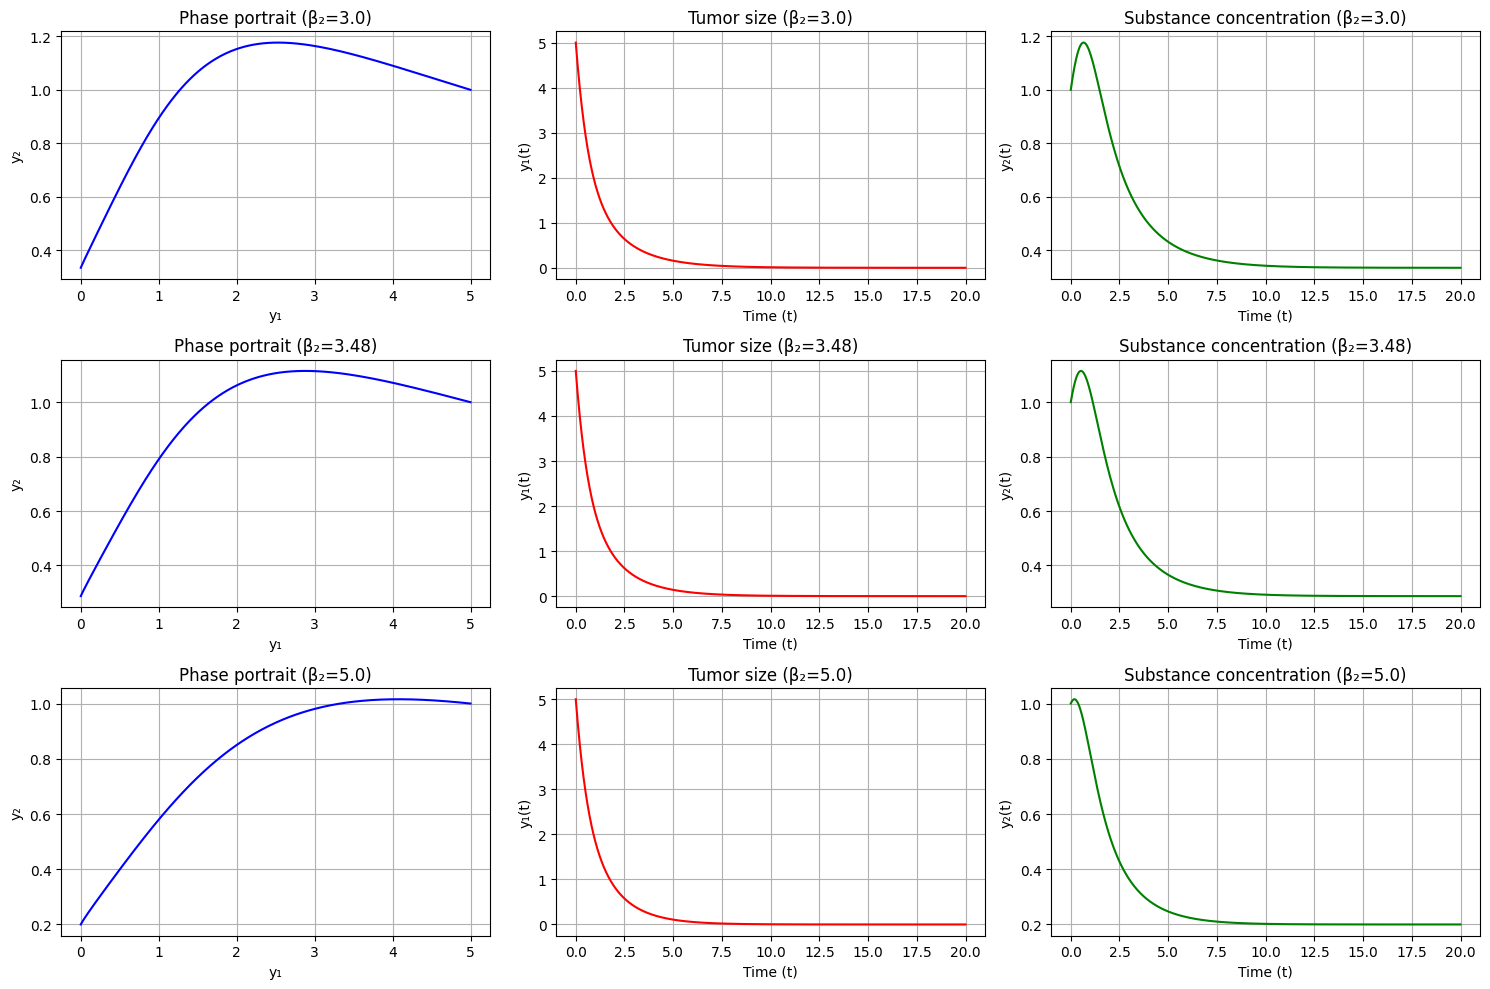

/usr/local/lib/python3.11/dist-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)


Calculations completed in 108.65 seconds


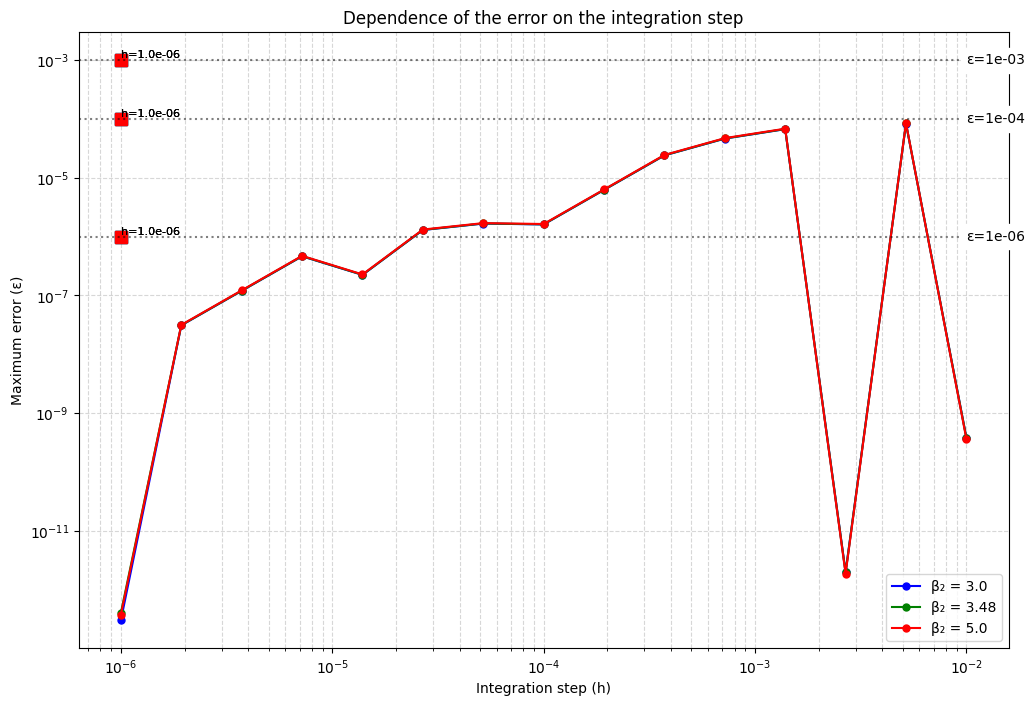


Optimal steps:
β₂		ε=1e-3		ε=1e-4		ε=1e-6
3.0		1.00e-06		1.00e-06		1.00e-06
3.48		1.00e-06		1.00e-06		1.00e-06
5.0		1.00e-06		1.00e-06		1.00e-06


In [3]:
!pip install numba
import numpy as np
import matplotlib.pyplot as plt
from numba import jit, prange
import time

lambda1 = lambda2 = 1.0
beta1 = 1.0
c = 3.0
beta2_values = np.array([3.0, 3.48, 5.0])
t0, tf = 0.0, 20.0
y0 = np.array([5.0, 1.0])
h_plot = 0.01
h_values = np.logspace(-6, -2, 15)
epsilons = np.array([1e-3, 1e-4, 1e-6])

@jit(nopython=True, fastmath=True)
def f(t, y, beta2):
    y1, y2 = y
    denom = 1.0 + y1
    if denom == 0:
        denom = 1e-12
    term = (1 - y1/c) / denom
    dy1 = (-lambda1 + beta1 * (y2**0.666667) * term) * y1
    dy2 = lambda2 * y2 - beta2 * y2**2 / denom
    return np.array([dy1, dy2])

@jit(nopython=True)
def runge_kutta_4(t0, tf, y0, h, beta2):
    n = int((tf - t0)/h) + 1
    t = np.linspace(t0, tf, n)
    y = np.zeros((n, 2))
    y[0] = y0
    for i in range(n - 1):
        k1 = f(t[i], y[i], beta2)
        k2 = f(t[i] + h/2, y[i] + h*k1/2, beta2)
        k3 = f(t[i] + h/2, y[i] + h*k2/2, beta2)
        k4 = f(t[i] + h, y[i] + h*k3, beta2)
        y[i+1] = y[i] + (h/6)*(k1 + 2*k2 + 2*k3 + k4)
    return t, y

@jit(nopython=True, parallel=True)
def calculate_errors(h_values, beta2_values):
    errors = np.zeros((len(beta2_values), len(h_values)))
    for i in prange(len(beta2_values)):
        for j in range(len(h_values)):
            h = h_values[j]
            if h == 0:
                h = 1e-12
            t, y = runge_kutta_4(t0, tf, y0, h, beta2_values[i])
            t_ref, y_ref = runge_kutta_4(t0, tf, y0, max(h/5, 1e-12), beta2_values[i])
            y_ref_interp = np.interp(t, t_ref, y_ref[:, 0])
            errors[i,j] = np.max(np.abs(y[:,0] - y_ref_interp))
    return errors

plt.figure(figsize=(15, 10))

for i, beta2 in enumerate(beta2_values):
    t, y = runge_kutta_4(t0, tf, y0, h_plot, beta2)
    y1, y2 = y[:, 0], y[:, 1]

    plt.subplot(3, 3, i*3 + 1)
    plt.plot(y1, y2, 'b-')
    plt.xlabel('y₁')
    plt.ylabel('y₂')
    plt.title(f'Phase portrait (β₂={beta2})')
    plt.grid(True)

    plt.subplot(3, 3, i*3 + 2)
    plt.plot(t, y1, 'r-')
    plt.xlabel('Time (t)')
    plt.ylabel('y₁(t)')
    plt.title(f'Tumor size (β₂={beta2})')
    plt.grid(True)

    plt.subplot(3, 3, i*3 + 3)
    plt.plot(t, y2, 'g-')
    plt.xlabel('Time (t)')
    plt.ylabel('y₂(t)')
    plt.title(f'Substance concentration (β₂={beta2})')
    plt.grid(True)

plt.tight_layout()
plt.show()

start_time = time.time()
errors = calculate_errors(h_values, beta2_values)
print(f"Calculations completed in {time.time() - start_time:.2f} seconds")

plt.figure(figsize=(12, 8))
colors = ['b', 'g', 'r']
for i in range(len(beta2_values)):
    plt.loglog(h_values, errors[i], 'o-', color=colors[i],
              label=f'β₂ = {beta2_values[i]}', markersize=5)
    for eps in epsilons:
        idx = np.where(errors[i] <= eps)[0]
        if len(idx) > 0:
            h_opt = h_values[idx[0]]
            plt.plot(h_opt, eps, 's', color=colors[i], markersize=8)
            plt.text(h_opt, eps, f'h={h_opt:.1e}', fontsize=8, ha='left', va='bottom')

for eps in epsilons:
    plt.axhline(eps, color='k', linestyle=':', alpha=0.5)
    plt.text(1e-2, eps, f'ε={eps:.0e}', va='center', backgroundcolor='w')

plt.xlabel('Integration step (h)')
plt.ylabel('Maximum error (ε)')
plt.title('Dependence of the error on the integration step')
plt.grid(True, which="both", ls="--", alpha=0.5)
plt.legend()
plt.show()

print("\nOptimal steps:")
print("β₂\t\tε=1e-3\t\tε=1e-4\t\tε=1e-6")
for i in range(len(beta2_values)):
    row = f"{beta2_values[i]}"
    for eps in epsilons:
        idx = np.where(errors[i] <= eps)[0]
        h_opt = h_values[idx[0]] if len(idx) > 0 else '---'
        row += f"\t\t{h_opt:.2e}" if isinstance(h_opt, float) else f"\t\t{h_opt}"
    print(row)